<a href="https://colab.research.google.com/github/andrewharris3/bank_marketing_sample/blob/main/Bank_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn import base
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import impute
from sklearn import pipeline
from sklearn import compose
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import ensemble
from sklearn import inspection
from sklearn import metrics
from imblearn import pipeline as imbpipe
from imblearn.over_sampling import SMOTE

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pymc3 as pm
import arviz as az

from typing import Tuple, Optional, Dict, List
import datetime
from functools import partial

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
seed = 100

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv


Source: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

**Summary:** The following problem comes from the paper [S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014. ](https://repositorio.iscte-iul.pt/bitstream/10071/9499/5/dss_v3.pdf). The high level problem is whether we can use customer information to determine whether or not a telephone contact would lead to a term deposit (which should be similar to a certificate of deposit, a relatively safe short term asset that produces a small return but far lower than what could be expected in equity or greater bond market).

I would expect the following to be true a priori:
* Age should be significant as one would expect older people already to have established financial services and not needing a new account.
* Job and Education type should be significant as well. One would expect higher education / higher level jobs be me likely already to have financial services in place.
* Credit in default should be a major red flag, and if it were offered at all, and might affect the finanicial decisions.
* Contact type would potentially be less significant although there is a significant age skew for those being contacted by land line. This is probably a high degree of correlation with age.
* Housing loans could be indicative of an appetite for more financial instruments, but it could be that the individual is a renter or has already paid off their home.
* A personal loan would probably follow a similar logic to housing loans.
* I would not expect either day of week or month to be predictive in and of themselves as there typically isn't a cyclic element to the demand for financial products. 
* Duration I would expect to be signficiant as a longer call would indicate higher interest than a short call. As this is probably log-normally distributed, it probably needs a log transform to normalize it. However this metric is only available after a call is complete and should be left out of the initial analysis. Yes, it's highly predictive but not available at a business relevant time.
* Campaign I would also expect to be signficant as interest might increase for additional contacts but then decrease and turn negative after reaching a critical number of calls.
* Like campaign, I would also expect pdays and previous, and poutcome to be significant. Probably highly so, as there is as there probably is a high degree of autocorrelation in interest in financial instruments.
* I would highly expect the financial conditions of the country at large to be signifcicant, with a special emphasis on the euribor3m rate which would almost certainly be the primary driver of a decision to invest. The underlying interest rate is the main part of a term deposit and hence should play a major factor in the decision to invest.

**Discussion:**
Per the discussion in the paper, we now that a neural net architecture had the best result with a ROC AUC score of 0.8. In general, boosting methods tend to have similar performance to neural nets for basic classification problems, so we will use that as a proxy for NN performance.

Additionally, a sensitivity analysis had been conducted however, I am curious as to the real effective difference between the methodologies and will be performing a bayesian analysis to compare results.

In [3]:
def ingest_dataframe(filepath: str) -> pd.DataFrame:
    """
    Particular categorical variables in the dataset would be more appropriately classified
    via an ordinal encoding and there are several indicators present in the data that indicate a 
    missing variable. This function serves to wrap that logic and present a high level preprocessing
    interface to the raw data.
    """

    # Helper Functions to support dtype construction
    def create_month_list(begin_month: int, end_month: int) -> Optional[List[str]]:
        if (begin_month > end_month) or (end_month > 12) or (begin_month < 1):
            return None
    
        else: 
            month_list = []
            for i in range(begin_month, (end_month + 1)):
                datetime_object = datetime.datetime.strptime(f"{i}", "%m")
                month_name = datetime_object.strftime("%b").lower()
                month_list.append(month_name)
            
            return month_list

    # To properly classify the appropriate dtypes based on problem domain
    education_dtype = CategoricalDtype(categories = ['illiterate', 'basic.4y','basic.6y',
                                                    'basic.9y','high.school','professional.course',
                                                    'university.degree'], ordered = True)
    month_dtype = CategoricalDtype(categories = create_month_list(1, 12), ordered = True)
    day_of_week_dtype = CategoricalDtype(categories = ['mon', 'tues', 'wed', 'thurs', 'fri'], ordered = True)

    apriori_dtypes = {
        
        # Demographics
        'age': 'int64',
        'job': 'category',
        'marital': 'category',
        'education': education_dtype,
        'default': 'category',
        'housing': 'category',
        'loan': 'category',
        
        # Last Contact
        'contact': 'category',
        'day_of_week': day_of_week_dtype,
        'month': month_dtype,
        'duration': 'float64',

        # Other Attributes
        'campaign': 'int64',
        'pdays': 'float64',
        'previous': 'int64',
        'poutcome': 'category',
        
        # Socio Economic Context Attributes
        'emp.var.rate': 'float64',
        'cons.price.idx': 'float64',
        'cons.conf.idx': 'float64',
        'euribor3m': 'float64',
        'nr.employed': 'float64',

        # Outcome
        'y': 'category'
    }

    df = pd.read_csv(
        filepath, 
        dtype = apriori_dtypes,
        na_values = ["999", "unknown", "nonexistent", "<NA>"],
        sep = ";"
    )

    return df

df = ingest_dataframe("bank-additional-full.csv")

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261.0,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149.0,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226.0,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151.0,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307.0,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  int64   
 1   job             40858 non-null  category
 2   marital         41108 non-null  category
 3   education       39457 non-null  category
 4   default         32591 non-null  category
 5   housing         40198 non-null  category
 6   loan            40198 non-null  category
 7   contact         41188 non-null  category
 8   month           41188 non-null  category
 9   day_of_week     24475 non-null  category
 10  duration        41186 non-null  float64 
 11  campaign        41188 non-null  int64   
 12  pdays           1515 non-null   float64 
 13  previous        41188 non-null  int64   
 14  poutcome        5625 non-null   category
 15  emp.var.rate    41188 non-null  float64 
 16  cons.price.idx  41188 non-null  float64 
 17  cons.conf.id

In [6]:
print(
    f"Calculate the relative counts and \n" 
    f"the frequency of the positive case\n"
    f"=========================================\n"
    f"{df.y.value_counts()} \n\n"
    f"{np.round(df.y.value_counts(normalize = True), 2)}"
)

Calculate the relative counts and 
the frequency of the positive case
no     36548
yes     4640
Name: y, dtype: int64 

no     0.89
yes    0.11
Name: y, dtype: float64


In [7]:
df = df.assign(y = lambda x : x.y.cat.codes)

In [8]:
def create_data_splits(df: pd.DataFrame, seed) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
  """
  To prevent data leakage, we will separate out a small EDA dataset out of the main training df in addition 
  to the normal train test split.
  """
  train_base, test_df = model_selection.train_test_split(df, test_size = 0.2, stratify = df[['y']], random_state = seed)
  eda_df, train_df = model_selection.train_test_split(train_base, train_size = 0.2, stratify = train_base[['y']], random_state = seed)
  return eda_df, train_df, test_df

eda, train, test = create_data_splits(df, seed = seed)

In [9]:
print(
    f"The EDA dataset has {eda.shape[0]:,} rows \n"
    f"The primary training dataset has {train.shape[0]:,} rows \n"
    f"The testing dataset has {test.shape[0]:,} rows"
)

The EDA dataset has 6,590 rows 
The primary training dataset has 26,360 rows 
The testing dataset has 8,238 rows


# Exploratory Data Analysis

In [10]:
eda.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
24700,35,admin.,married,NaN,no,yes,no,cellular,nov,mon,960.0,2,NaN,0,NaN,-0.1,93.200,-42.0,4.191,5195.8,0
25046,38,management,married,university.degree,no,no,no,cellular,nov,NaN,61.0,1,NaN,0,NaN,-0.1,93.200,-42.0,4.153,5195.8,0
1499,38,blue-collar,married,basic.6y,NaN,no,no,telephone,may,NaN,132.0,2,NaN,0,NaN,1.1,93.994,-36.4,4.855,5191.0,0
1129,45,blue-collar,married,basic.9y,NaN,yes,no,telephone,may,wed,944.0,3,NaN,0,NaN,1.1,93.994,-36.4,4.856,5191.0,0
22987,44,technician,married,professional.course,no,yes,no,cellular,aug,mon,63.0,6,NaN,0,NaN,1.4,93.444,-36.1,4.965,5228.1,0
32743,48,admin.,divorced,basic.4y,no,yes,no,cellular,may,mon,227.0,1,NaN,0,NaN,-1.8,92.893,-46.2,1.299,5099.1,0
3378,58,retired,divorced,university.degree,no,yes,no,telephone,may,NaN,30.0,2,NaN,0,NaN,1.1,93.994,-36.4,4.860,5191.0,0
16310,46,blue-collar,married,basic.4y,NaN,no,no,cellular,jul,NaN,203.0,4,NaN,0,NaN,1.4,93.918,-42.7,4.961,5228.1,0
15535,56,admin.,married,university.degree,no,no,no,cellular,jul,fri,139.0,5,NaN,0,NaN,1.4,93.918,-42.7,4.957,5228.1,0
16575,26,services,single,high.school,no,NaN,NaN,telephone,jul,wed,588.0,1,NaN,0,NaN,1.4,93.918,-42.7,4.963,5228.1,0


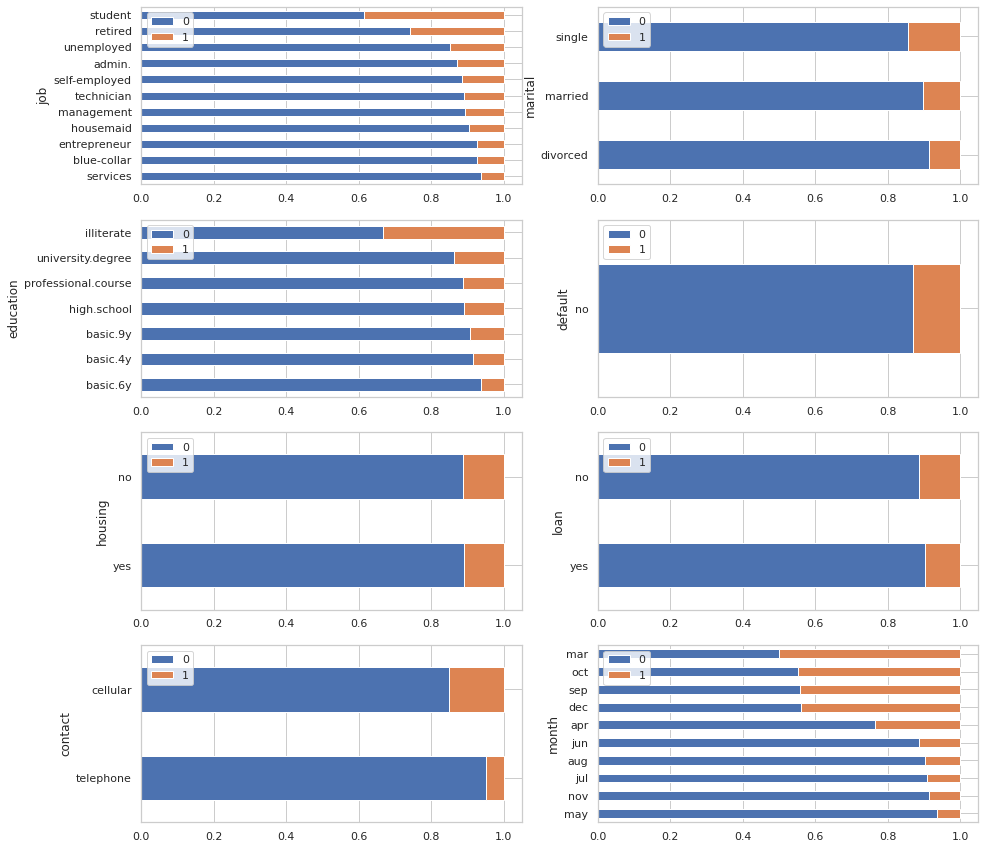

In [11]:
categories = eda.select_dtypes("category").join(eda.y)
category_names = categories.drop(columns = "y").columns


fig, axes = plt.subplots(4, 2, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
  pd.crosstab(categories[category_names[i]], eda.y, normalize = 0).sort_values(1).plot.barh(stacked = True, ax = ax)
  ax.legend(loc = "upper left")

In [12]:
categories.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
12231,blue-collar,married,basic.4y,NaN,yes,yes,telephone,jul,NaN,NaN,0
698,entrepreneur,married,basic.9y,no,no,no,telephone,may,NaN,NaN,0
36869,technician,married,professional.course,no,yes,no,cellular,jun,NaN,failure,0
29662,admin.,single,university.degree,no,yes,no,cellular,apr,mon,NaN,0
1869,blue-collar,married,basic.4y,no,yes,no,telephone,may,fri,NaN,0


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


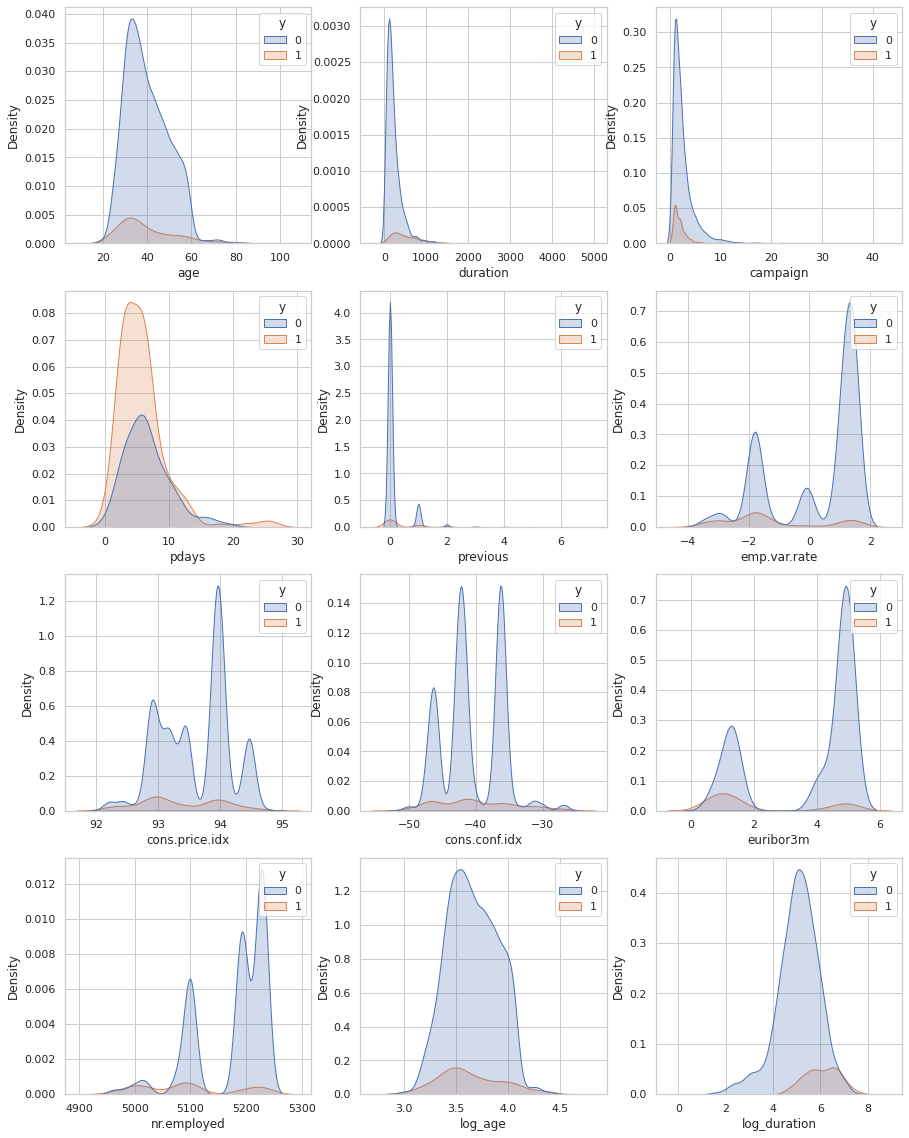

In [13]:
numerical = eda.select_dtypes("number").assign(**{
    "log_age": lambda x: np.log(x.age),
    "log_duration": lambda x: np.log(x.duration)
})
numerical_names = numerical.drop(columns = "y").columns

fig, axes = plt.subplots(4, 3, figsize=(15,20))
for i, ax in enumerate(axes.ravel()):
  sns.kdeplot(data = numerical, x = numerical_names[i], cumulative = False, hue="y", fill=True, ax = ax)

In [14]:
eda_y, eda_X = patsy.dmatrices("y ~ marital + default + housing + loan + contact + poutcome + education + month + np.log(age) + np.log(duration) + np.log(campaign)", data = eda, return_type = "dataframe")

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
exploratory_model = smf.logit("y ~ marital + housing + loan + contact + poutcome + np.log(age) + np.log(duration) + np.log(campaign)", data = eda).fit()

Optimization terminated successfully.
         Current function value: 0.406532
         Iterations 7


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
exploratory_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  843
Model:                          Logit   Df Residuals:                      833
Method:                           MLE   Df Model:                            9
Date:                Thu, 12 May 2022   Pseudo R-squ.:                  0.2949
Time:                        13:05:45   Log-Likelihood:                -342.71
converged:                       True   LL-Null:                       -486.01
Covariance Type:            nonrobust   LLR p-value:                 1.798e-56
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -8.6702      1.753     -4.947      0.000     -12.105      -5.235
marital[T.married]      -0.1557      0.322     -0.483      0.629      -0.787       0.476
marital[T.single]        0.0738      0.369      0.200      0.841      -0.648       0.796
housing[T.yes]          -0.1806      0.194     -0.930      0.352      -0.561       0.200
loan[T.yes]             -0.2137      0.280     -0.764      0.445      -0.762       0.334
contact[T.telephone]    -0.4927      0.471     -1.046      0.295      -1.416       0.430
poutcome[T.success]      2.4198      0.207     11.703      0.000       2.015       2.825
np.log(age)              0.0302      0.380      0.080      0.936      -0.714       0.774
np.log(duration)         1.2926      0.151      8.566      0.000       0.997       1.588
np.log(campaign)        -0.1072      0.184     -0.583      0.560      -0.468       0.253
========================================================================================
"""

In [17]:
exploratory_model_no_duration = smf.logit("y ~ marital + housing + loan + contact + poutcome + np.log(age) + np.log(campaign)", data = eda).fit()
exploratory_model_no_duration.summary()

Optimization terminated successfully.
         Current function value: 0.462206
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  843
Model:                          Logit   Df Residuals:                      834
Method:                           MLE   Df Model:                            8
Date:                Thu, 12 May 2022   Pseudo R-squ.:                  0.1983
Time:                        13:05:45   Log-Likelihood:                -389.64
converged:                       True   LL-Null:                       -486.01
Covariance Type:            nonrobust   LLR p-value:                 2.154e-37
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.1355      1.400     -0.811      0.417      -3.880       1.609
marital[T.married]      -0.2037      0.299     -0.680      0.496      -0.790       0.383
marital[T.single]        0.0008      0.342      0.002      0.998      -0.670       0.672
housing[T.yes]          -0.1759      0.182     -0.967      0.334      -0.532       0.181
loan[T.yes]             -0.2433      0.267     -0.913      0.361      -0.766       0.279
contact[T.telephone]    -0.4543      0.415     -1.095      0.273      -1.267       0.359
poutcome[T.success]      2.4619      0.192     12.847      0.000       2.086       2.837
np.log(age)             -0.0825      0.356     -0.232      0.817      -0.781       0.616
np.log(campaign)        -0.1618      0.167     -0.972      0.331      -0.488       0.165
========================================================================================
"""

# Modeling in Sklearn

In [18]:
Repeated10Fold = model_selection.RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = seed)

In [19]:
one_hot_pipe = pipeline.Pipeline([
    ("one_hot_impute", impute.SimpleImputer(strategy = "constant", fill_value = "missing")),
    ("one_hot_encode", preprocessing.OneHotEncoder(handle_unknown = "ignore"))                  
])

ordinal_pipe = pipeline.Pipeline([
    ("ordinal_impute", impute.SimpleImputer(strategy = "constant", fill_value = "missing")),
    ("ordinal_encode", preprocessing.OrdinalEncoder())
])

logged_pipe = pipeline.Pipeline([
    ('logged_impute', impute.SimpleImputer(strategy = "median")),
    ('logged_transform', preprocessing.PowerTransformer())
])

numeric_pipe = pipeline.Pipeline([
    ("numeric_impute", "passthrough")
])

composed = compose.ColumnTransformer([
    ('one_hots', one_hot_pipe, ['marital', 'default', 'housing', 'loan', 'contact', 'poutcome']),
    ('ordinals', ordinal_pipe, ['education', 'month']),
    ('logs', logged_pipe, ['age', 'campaign']),
    ('numerics', numeric_pipe, ['emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed'])
])

whole_pipe = imbpipe.Pipeline([
    ("compose", composed),
    ("oversample", SMOTE(random_state = seed)),
    ("clf", naive_bayes.BernoulliNB())
])

In [20]:
params = [
    {
        "clf": [ensemble.HistGradientBoostingClassifier()],
        "clf__random_state": [seed],
        "clf__learning_rate": np.logspace(-5, -1),
        "clf__max_iter": np.logspace(2, 4, 3).astype(int),
        "clf__max_leaf_nodes": np.linspace(2, 10).astype(int),
        "clf__max_depth": [3],
        "clf__l2_regularization": scipy.stats.uniform(0, 1),
        "clf__tol": np.logspace(-5, -2)
    },

    {
        "clf": [naive_bayes.BernoulliNB()]
    }
]

In [21]:
number_of_init = 5
randomized_search = model_selection.RandomizedSearchCV(
    whole_pipe, 
    param_distributions = params, 
    n_jobs = -1, 
    cv = Repeated10Fold, 
    random_state = seed, 
    n_iter = number_of_init,
    scoring = 'roc_auc'
)

In [22]:
%%time
randomized_search.fit(train.drop(columns = 'y'), train.y)

CPU times: user 7.93 s, sys: 585 ms, total: 8.52 s
Wall time: 2min 38s


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=100),
                   estimator=Pipeline(steps=[('compose',
                                              ColumnTransformer(transformers=[('one_hots',
                                                                               Pipeline(steps=[('one_hot_impute',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='constant')),
                                                                                               ('one_hot_encode',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['marital',
                                      

In [23]:
randomized_search.best_score_

0.7820570965461944

In [24]:
randomized_search.best_estimator_

Pipeline(steps=[('compose',
                 ColumnTransformer(transformers=[('one_hots',
                                                  Pipeline(steps=[('one_hot_impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'poutcome']),
                                                 ('ordinals',
                                                  Pipeline(steps=[('ordinal_impute',
                                                         

In [25]:
metaresults = pd.DataFrame(randomized_search.cv_results_).sort_values("rank_test_score")
metaresults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__l2_regularization,param_clf__learning_rate,param_clf__max_depth,param_clf__max_iter,param_clf__max_leaf_nodes,param_clf__random_state,param_clf__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
3,2.035022,0.226790,0.052627,0.004961,HistGradientBoostingClassifier(l2_regularizati...,0.575093,0.008685,3,100,4,100,0.000036,{'clf': HistGradientBoostingClassifier(l2_regu...,0.768858,0.784393,0.770621,0.781986,0.775280,0.782949,0.801216,0.780919,0.776671,0.794071,0.802460,0.782815,0.761366,0.764634,0.778041,0.763426,0.774146,0.807386,0.782740,0.793697,0.771905,0.773071,0.797447,0.787484,0.781348,0.778593,0.794016,0.786750,0.795093,0.760263,0.790122,0.784863,0.782538,0.785461,0.796922,0.774698,0.785022,0.771246,0.786146,0.763743,0.763337,0.743755,0.794444,0.794049,0.775788,0.796875,0.760730,0.799403,0.784527,0.815539,0.782057,0.013869,1
0,1.890366,0.118614,0.052371,0.005255,HistGradientBoostingClassifier(l2_regularizati...,0.671156,0.015264,3,100,3,100,0.000687,{'clf': HistGradientBoostingClassifier(l2_regu...,0.771299,0.777997,0.769330,0.782455,0.773584,0.784921,0.798636,0.770513,0.776382,0.790036,0.802692,0.781374,0.762728,0.761819,0.777493,0.767447,0.773777,0.799896,0.780624,0.794249,0.768343,0.780379,0.797318,0.776807,0.779888,0.775280,0.791712,0.787013,0.797675,0.751888,0.786831,0.782721,0.784594,0.785305,0.786677,0.774939,0.785559,0.766583,0.782407,0.759528,0.757211,0.741700,0.793875,0.793098,0.772617,0.791607,0.755545,0.795898,0.779697,0.809817,0.779795,0.013862,2
1,0.868600,0.020608,0.032380,0.007213,HistGradientBoostingClassifier(l2_regularizati...,0.121569,0.000015,3,10000,4,100,0.001207,{'clf': HistGradientBoostingClassifier(l2_regu...,0.753126,0.756002,0.763283,0.752548,0.760397,0.769006,0.773221,0.754490,0.761100,0.762279,0.773767,0.753452,0.749136,0.752164,0.751554,0.754180,0.755739,0.782961,0.750747,0.782460,0.746457,0.747457,0.772276,0.760407,0.755671,0.778074,0.764571,0.766189,0.774158,0.740713,0.769261,0.763865,0.753085,0.764585,0.773847,0.745234,0.753596,0.758370,0.775187,0.748256,0.745409,0.722771,0.779647,0.767950,0.747561,0.781374,0.738307,0.771444,0.769078,0.787437,0.760677,0.013121,3
2,0.563031,0.020055,0.032291,0.004396,BernoulliNB(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'clf': BernoulliNB()},0.721290,0.742085,0.733500,0.746075,0.732721,0.740106,0.730023,0.728863,0.721798,0.747019,0.758186,0.735002,0.729266,0.714092,0.725951,0.714475,0.737554,0.744670,0.754456,0.731300,0.731111,0.727835,0.761806,0.737551,0.737865,0.723962,0.724538,0.741973,0.756847,0.697156,0.735597,0.744879,0.746426,0.747964,0.731909,0.738756,0.741831,0.710924,0.727810,0.717082,0.706368,0.699952,0.744717,0.746931,0.726407,0.742878,0.736508,0.739446,0.722196,0.771674,0.734187,0.014903,4
4,0.564464,0.020453,0.031584,0.003904,BernoulliNB(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'clf': BernoulliNB()},0.721290,0.742085,0.733500,0.746075,0.732721,0.740106,0.730023,0.728863,0.721798,0.747019,0.758186,0.735002,0.729266,0.714092,0.725951,0.714475,0.737554,0.744

In [27]:
scores = metaresults.loc[:, 'split0_test_score':'split49_test_score'].reset_index().rename(columns = {"index": "model_number"})
melted_scores = pd.melt(scores, id_vars = 'model_number').astype({'model_number': 'category'})
transformed = melted_scores.assign(normalized = melted_scores[['value']].apply(lambda x: (x - x.mean()) / x.std()))

# Validate Differences Between Models

In [28]:
with pm.Model() as bayes_model:
    sigma = pm.Exponential("sigma", 1, shape = number_of_init)
    mu = pm.Normal("mu", 0, 1, shape = number_of_init)
    likelihood = pm.Normal("likelihood", 
                           mu = mu[transformed.model_number.cat.codes], 
                           sigma = sigma[transformed.model_number.cat.codes], 
                           observed = transformed['normalized'])

    prior_predictive = pm.sample_prior_predictive(random_seed = seed)
    trace = pm.sample(10000, random_seed = seed)
    posterior_predictive = pm.sample_posterior_predictive(trace = trace, random_seed = seed)

    model_diagnostics = az.from_pymc3(trace = trace, prior = prior_predictive, posterior_predictive = posterior_predictive)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # Remove the CWD from sys.path while we load stuff.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f303095f590>,
      dtype=object)

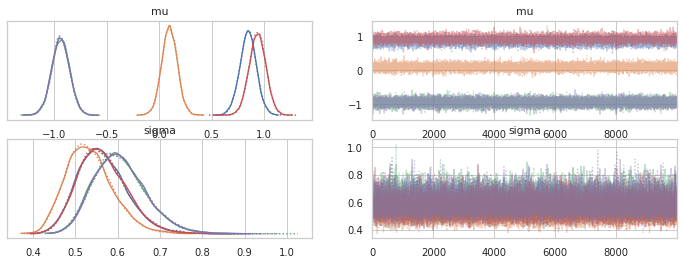

In [29]:
az.plot_trace(model_diagnostics)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f30300a3990>],
      dtype=object)

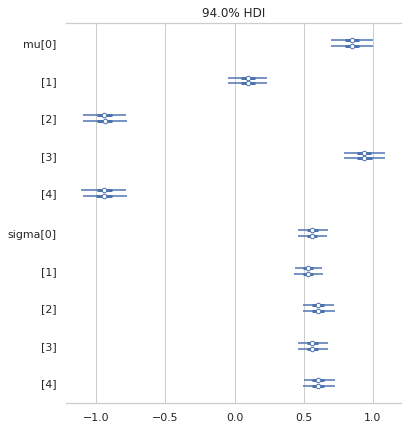

In [30]:
az.plot_forest(model_diagnostics)

Based on the regions of pratical equivalence, the boosting methods strictly outperform the naive bayes implemention. Interesting to note as well the relative performance of the hyperparameters selection in the boosting model. Both of these outcomes are expected but good to validate

# Assess the post-hoc feature importances

In [65]:
feature_importance = inspection.permutation_importance(randomized_search, train.drop(columns = 'y'), train.y, random_state = seed)
feature_importance_means = feature_importance.importances_mean
feature_order = feature_importance_means.argsort()

sorted_feature_importance_means = feature_importance_means.copy()
sorted_feature_importance_means.sort()

In [69]:
feature_order

array([ 0, 17, 13, 12, 11, 10, 18,  9,  6,  5,  3,  2,  1, 16,  4, 14,  8,
        7, 15, 19])

In [70]:
index_values = randomized_search.feature_names_in_[feature_order]

In [73]:
importance_series = pd.Series(sorted_feature_importance_means, index = index_values)

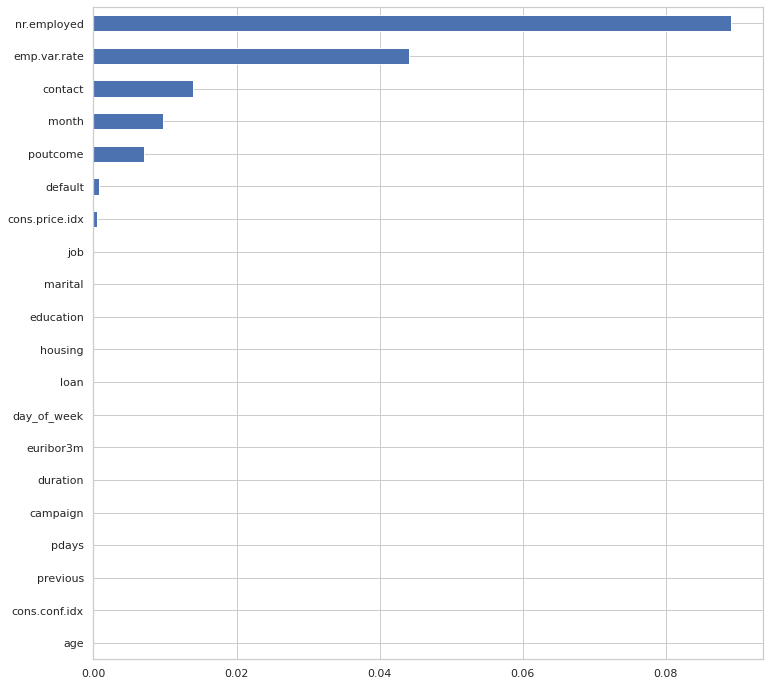

In [75]:
fig, ax = plt.subplots(figsize = (12, 12))
importance_series.plot.barh()